# Tratando dados do levantamento físico e banco de dados Suap

In [1]:
import pandas as pd

#total geral = 10044; total livros = 4706; total geral sem livros = 5355

suap = pd.read_excel('suap.xlsx')
# print('suap info')
# display(suap.info())

priori= pd.read_excel('priori_completo.xlsx')

# capturando segunda planilha e removendo coluna observação
priori2 = pd.read_excel('priori_completo.xlsx', sheet_name=1)
priori2 = priori2.drop(columns='Observação')

# juntando planilhas
priori = pd.concat([priori, priori2])

priori_ED = priori['C. Custo'].drop_duplicates()
priori_ED = priori_ED.drop([6606, 6607])
# IFPE449052-99 IFPE449052-87 elementos de despesa dropados

priori_ED = priori_ED.sort_values(ascending=True)
#reindexando uutilizando list comprehension
priori_ED.index = [x for x in range(0, len(priori_ED))]

# display(priori.info())
priori
# priori_livros = priori[priori['ED_priori'].str.contains('449052-18')]
# priori = priori[priori['ED_priori'].str.contains('449052-18')==False]
# display(priori.info())


,Nome Local,Nr. Ativo,Descrição,C. Custo,Nome Cond. Uso,Desc. Status,Data transação
0,1150 - AFI - BLOCO A - AREA EXTERNA/PORTARIA -...,83303,"BEBEDOURO ÁGUA, TIPO INDUSTRIAL, COM 3 TORNEIR...",IFPE449052-34,5 - NORMAL,A - ALT INV,23/08/2021
1,1150 - AFI - BLOCO A - AREA EXTERNA/PORTARIA -...,92695,TELEVISÃO LCD 32 POL. SAMSUNG,IFPE449052-33,5 - NORMAL,A - ALT INV,23/08/2021
2,1150 - AFI - BLOCO A - AREA EXTERNA/PORTARIA -...,101796,"QUADRO DE AVISOS, MATERIAL CORTIÇA, COMP 90 CM...",IFPE449052-42,5 - NORMAL,A - ALT INV,23/08/2021
3,1150 - AFI - BLOCO A - AREA EXTERNA/PORTARIA -...,101797,"QUADRO DE AVISOS, MATERIAL CORTIÇA, COMP 90 CM...",IFPE449052-42,5 - NORMAL,A - ALT INV,23/08/2021
4,1150 - AFI - BLOCO A - AREA EXTERNA/PORTARIA -...,102717,PAR DE RADIOS TANSCEPTORES.,IFPE449052-06,5 - NORMAL,A - ALT INV,01/09/2021
...,...,...,...,...,...,...,...
57,Selecione - CONFIRA o LOCAL - CAMPUS - PREDIO ...,220750,METODOLOGIA DE PESQUISA PARA A CIÊNCIA DA COMP...,IFPE449052-18,5 - NORMAL,A - ALT INV,24/08/2021
58,Selecione - CONFIRA o LOCAL - CAMPUS - PREDIO ...,222668,INTRODUÇÃO A INFORMÁTICA - CAPRON/JOHNSON 8 ED...,IFPE449052-18,5 - NORMAL,A - ALT INV,24/08/2021
59,Selecione - CONFIRA o LOCAL - CAMPUS - PREDIO ...,223267,AS REGRAS DO MÉTODO SOCIOLÓGICO - DURKHEIM - 1...,IFPE449052-18,5 - NORMAL,A - ALT INV,24/08/2021
60,Selecione - CONFIRA o LOCAL - CAMPUS - PREDIO ...,606358,"MONITOR ITAUTEC LCD 19""\nM786401746267",IFPE449052-35,1 - SUCATA / INSERVIVEL IRRECUPERAVEL,A - ALT INV,27/08/2021


In [2]:
livros1 = pd.read_table("parte 1 biblio.xls")
livros2 = pd.read_table("parte 2 biblio.xls")
livros3 = pd.read_table("parte 3 biblio.xls")
livros4 = pd.read_table("parte 4 biblio.xls")
livros5 = pd.read_table("parte 5 biblio.xls")

suap_livros = pd.concat([livros1, livros2, livros3, livros4, livros5])

suap_total = pd.concat([suap, suap_livros])
suap_total['DATA DA ENTRADA'] = pd.to_datetime(suap_total['DATA DA ENTRADA'])
# dropando itens com entrada após abril 2021
suap_total = suap_total[suap_total['DATA DA ENTRADA'] < '2021-05-01']
# print(suap_total.info())
# dropando itens levantados virtualmento pela priori 
# suap_mod = suap_total[suap_total['DESCRICAO'].str.contains('MÓDULO DIDÁTICO,')]

lista_drop = ['MÓDULO DIDÁTICO,', 'PLACA DE GESSO ACARTONADO', 'PORTA PARA DIVISÓRIA', 'Conjunto de guarda corpo medindo', 
             'PAR de corrimão em ferro', 'COBERTURA LEVE', 'KIT SALA MODULAR', 'CADEIRA ESCOLAR EM RESINA', 
             'CARTEIRA ESCOLAR - EM RESINA', 'CADEIRA PLASTICA UNIVERSAL',
             'CADEIRA ESCOLAR', 'CADEIRA COMUM. CADEIRA DE PLÁSTICO', 'MESA QUADRADA DE PLÁSTICO', 
             'POLTRONA PRANCHETA EM RESINA']



suap_ED = suap_total['ED'].drop_duplicates()
suap_ED = suap_ED.sort_values(ascending=True)

#reindexando uutilizando list comprehension
suap_ED.index = [x for x in range(0, len(suap_ED))]
# print(len(suap_ED))

In [3]:
def dropar_descricao(data_frame, coluna, lista):

    for item in lista:
#         data_drop = data_frame[data_frame[coluna].str.contains(item)]
        data_frame = data_frame[data_frame[coluna].str.contains(item)==False]
#         print(f'{item} - {len(data_drop)}')
    return data_frame

priori = dropar_descricao(priori, 'Descrição', lista_drop)
suap_total = dropar_descricao(suap_total, 'DESCRICAO', lista_drop)

# print(suap_total.info())

In [4]:
suap_merge = suap_total[['NUMERO', 'SALA', 'DESCRICAO', 'CARGA ATUAL', 'ED']]
priori_merge = priori[['Nr. Ativo', 'Nome Local', 'Descrição', 'C. Custo']]
priori_merge = priori_merge.rename(columns={'Nr. Ativo': 'NUMERO', 'Nome Local': 'SALA_priori', 'Descrição': 'DESCRICAO_priori', 'C. Custo': 'ED_priori'})
# display(priori_merge.info())
# display(suap_merge.info())

diferenca = pd.merge(suap_merge, priori_merge, on='NUMERO', how='outer', indicator=True)

diferenca.to_excel('diferenca_total.xlsx', index=False)

In [5]:
#montar data frame pra o gráfico
chart_df = pd.DataFrame()
chart_df['ED'] = suap_ED
suap_conta = []
priori_conta = []

for ed in chart_df['ED']:
    conta_s = suap_total[suap_total['ED'].str.contains(ed)]
    suap_conta.append(len(conta_s))
    conta_p = priori[priori['C. Custo'].str.contains(ed)]
    priori_conta.append(len(conta_p))
    
chart_df['QTD_SUAP'] = suap_conta
chart_df['QTD_PRIORI'] = priori_conta

total = {'ED': 'TOTAL', 'QTD_PRIORI': sum(priori_conta), 'QTD_SUAP': sum(suap_conta)}

chart_df = chart_df.append(total, ignore_index=True)

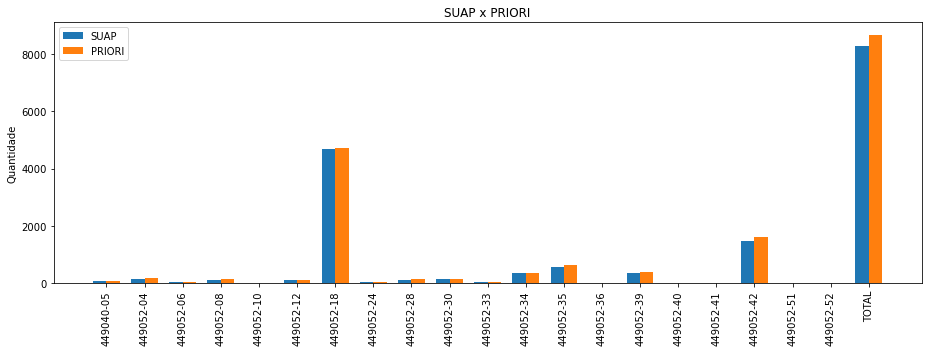

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# ax = chart_df[['QTD_SUAP', 'QTD_PRIORI']].plot(figsize=(12,8), kind='bar')
# ax.set_xticklabels(chart_df['ED'])

labels = chart_df['ED']
bars = chart_df['QTD_SUAP']
barp = chart_df['QTD_PRIORI']

# plt.figure()

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(13,5))

barra1 = ax.bar(x - width/2, bars, width=width, label='SUAP')
barra2 = ax.bar(x + width/2, barp, width=width, label='PRIORI') 

ax.set_ylabel('Quantidade')
ax.set_title('SUAP x PRIORI')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
ax.legend()



# ax.bar_label(barra1, padding=3) não tá funcionandp, provalvemente precisa atualização

fig.tight_layout()


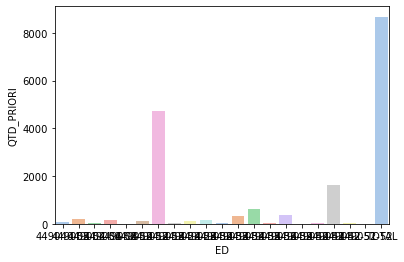

In [7]:
import seaborn as sns
grafico = sns.barplot(x='ED', y='QTD_PRIORI', data=chart_df, palette='pastel')